## Attacking MNIST Dataset

Here we use a custom NN trained on MNIST data to perform *zero order Stochastic Gradient Descent*

**1. Set current directory**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/AdvAttack

/content/gdrive/My Drive/Colab Notebooks/AdvAttack


In [1]:
import src.loss as customLoss
import src.ZOOptim as ZOOptim
import src.dataset as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import math


import torch
from src.models import MnistNet
from torchvision import transforms
from torch import nn, optim

**2. Import libraries**

**3. Retrieve MNIST data**

We retrieve the MNIST data. <br>
The 'standard' *trasnform.compose* method just convert the data to *torch.Tensor* without any rescaling or normalizzation


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


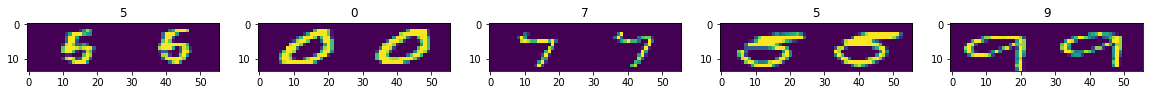

In [2]:
DataLoader = data.MNIST(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
DataLoader.get_info()

**4. Retrieve the network**

In [6]:
device = torch.device('cuda')
net = MnistNet().to(device)
net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))

<All keys matched successfully>

### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Zero-order Stochastic Conditional Gradient* to modify the image in order to make the network be mistaken.

We can set an epsilon as an upper bound for the inifinity norm of our input.

**Args:**

        Name            Type                Description
        
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        mk:             (list)              Number of normal vector to generate at every step
        ak              (list)              Pseudo learning rate/momentum  every step
        epsilon:        (float)             The upper bound of the infinity norm
        C:              (tuple)             The boundaries of the pixel. Default is (0, 1)
        max_steps:      (int)               The maximum number of steps. Default is 100
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False

**Suggested values** <br>
*Zeroth-order Nonconvex Stochastic Optimization: Handling Constraints, High-Dimensionality and Saddle-Points* (rishnakumar Balasubramanian†1 and Saeed Ghadimi‡2):

$v = \sqrt{\frac{2B_{L_{\sigma}}}{N(d+3)^3}}$, 
$\alpha_{k} =\frac{1}{\sqrt{N}}$,
$m_{k} = 2B_{L_{\sigma}}(d + 5)N$,
$\forall k \geq 1$

where:<br>
- *N* is the number of steps <br>
- *d* is the dimension of *x* <br>
- $B_{L_{\sigma}} ≥ max\bigg\{\sqrt{\frac{B^2 + \sigma^2}{L}}, 1\bigg\}$

**E.G:** <br>
If we set $N = 100$, $B_{L_{\sigma}} = 1$ and we have a image 28 * 28 ($d = 784$) we have: <br>

- $v = 10e-6$
- $\alpha_{k} = 0.1$
- $m_{k} = 15780$

**N.B** <br>
In reality it seems that $\alpha_{k}$ could be set much higher (e.g. 0.5)  and $m_{k}$ could be set much lower (e.g. 600)  

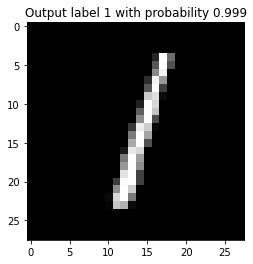

In [26]:
### Get an input used as test
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    break

net.eval()
img_orig = X[2].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[2].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

**5.1 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

*E.g.* <br> 
We want to try to maximise the probability of classification of neuron *eight*

100%|██████████| 300/300 [00:02<00:00, 120.15it/s]


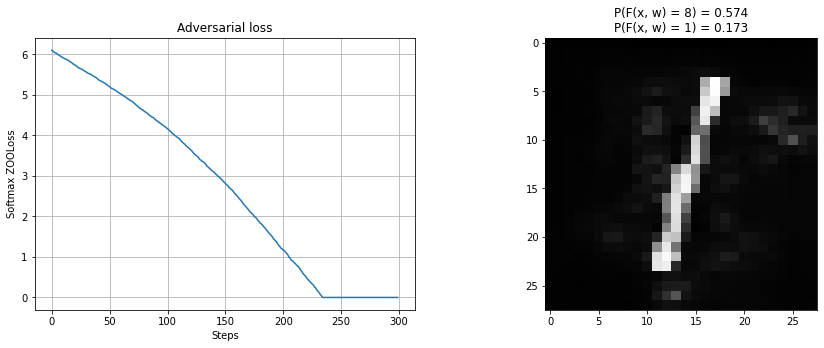

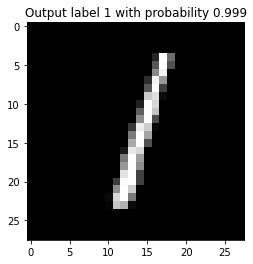

In [39]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=8, maximise=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')
optimizer = "adam"
### Run the optimizer
x, loss, outs = adv_optimizer.run(X[2], 
                                  c               =  0.4,
                                  learning_rate = 0.1,
                                  verbose         =  0,
                                  max_iterations = 300,
                                  optimizer = optimizer,
                                  additional_out  =  False)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('Softmax ZOOLoss')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),
                                                                             original_label, float(out[0, original_label])))
plt.show()

plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig)
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

**5.2 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to manimize the probability of classification of neuron *zero*

100%|██████████| 550/550 [00:04<00:00, 122.17it/s]


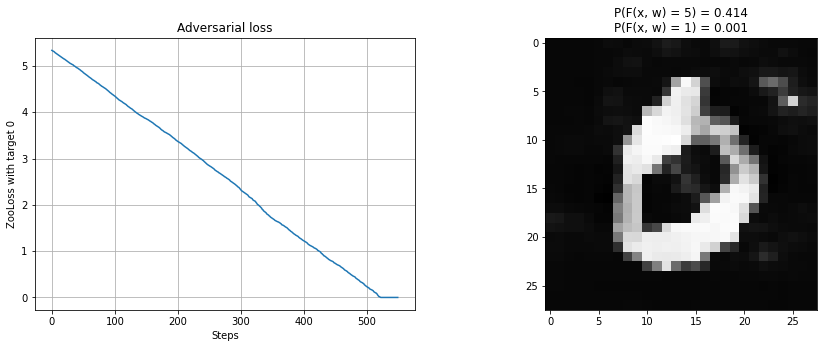

In [40]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=0, maximise=0, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(net, adv_loss, 'cuda')
optimizer = "adam"
### Run the optimizer
x, loss, outs = adv_optimizer.run(X[3], 
                                  c               =  0.4,
                                  learning_rate = 0.1,
                                  verbose         =  0,
                                  optimizer = optimizer,
                                  max_iterations = 550,
                                  additional_out  =  False)


### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('ZooLoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]), 
                                                                             original_label, float(out[0, original_label])))
plt.show()

**Success rate at different infinity norm upper bound**

Here we can see how the algorithm perform when it goes from stricter to less strict epsilon with the first 10 validation images.

**BETTER ON COLAB**

In [46]:
device = torch.device('cuda')
EPOCH = 100
optimizer = "adam"
def evaluate(n_iter, n=7, mk=28**2, ak=0.8, v=0.2):
    X_test = X[:n, ...]
    success = []
    xs = []
    for x in tqdm(X_test):
        y_before = int(torch.argmax(net(x.to(device).view(1, 1, 28, 28))))
        loss = customLoss.ZooLoss(neuron=y_before, maximise=0, dim=1)
        ADVoptim = ZOOptim.ZOOptim(model=net, loss=loss, device=device)
        x_out, loss_curve, out =  ADVoptim.run(x, 
                                               c               =  0.4,
                                               learning_rate = 0.1,
                                               verbose         =  0,
                                               optimizer = optimizer,
                                               max_iterations = n_iter,
                                               additional_out  =  False)

        if int(torch.argmax(net(x_out.reshape(1, 1, 28, 28))).item()) != y_before:
            success.append(1)
        else:
            success.append(0)
        xs.append(x_out)
    return success, xs

net = net.to(device)
n_iter = 600
success_list, out_list = evaluate(n_iter, ak=0.9)
print('Success rate:\t{:.1f}%'.format(100*np.sum(success_list)/len(success_list)))

100%|██████████| 7/7 [00:35<00:00,  5.14s/it]

Success rate:	100.0%


100%|██████████| 7/7 [00:31<00:00,  4.43s/it]


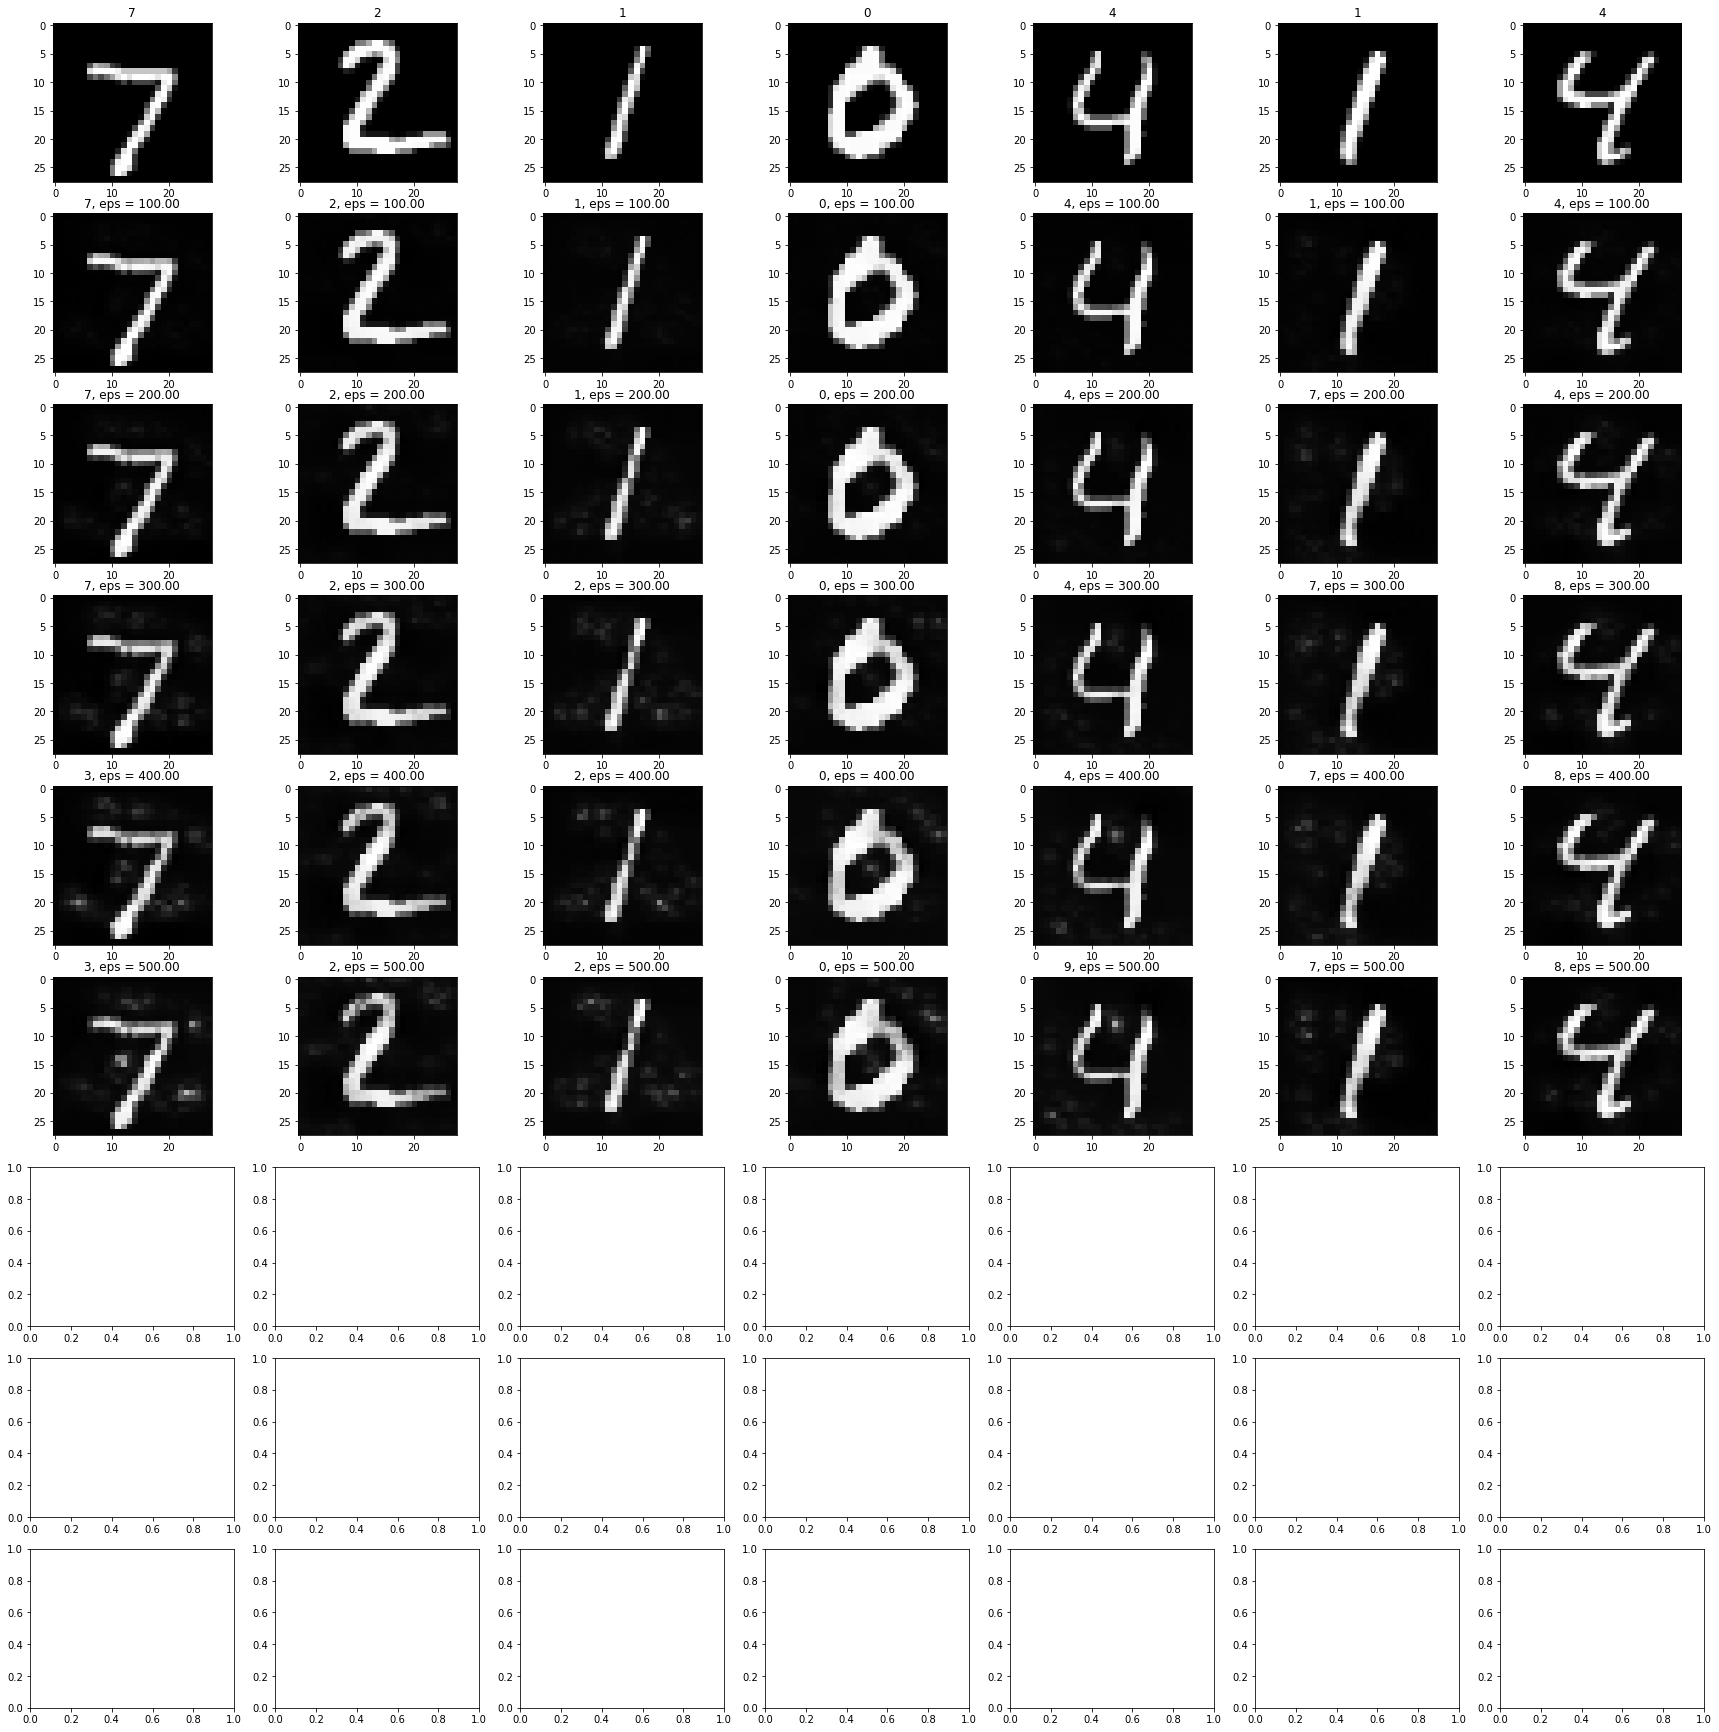

In [52]:
fig, ax = plt.subplots(9, 7, figsize = (30, 31))
for n in range(7):
    out_before = int(torch.argmax(net(X[n, ...].to(device).view(1, 1, 28, 28))))
    img_before = X[n, ...].detach().cpu().numpy()
    ax[0, n].imshow(img_before.reshape(28, 28), cmap='gray')
    ax[0, n].set_title(out_before)
for i in range(1,6):
    a1, b1 = evaluate(i*100)
    for n, t in enumerate(zip(a1, b1)):
        out_after = int(torch.argmax(net(t[1].view(1, 1, 28, 28))))
        img_after = t[1].detach().cpu().numpy()
        ax[i, n].imshow(img_after.reshape(28, 28), cmap='gray')
        ax[i, n].set_title('{}, iterations = {:.2f}'.format(out_after, float(i*100)))
plt.show()